In [1]:
%pip install -q yfinance transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import torch
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import yfinance as yf
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-03-25 12:02:18.827799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 12:02:18.827931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 12:02:18.973134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load and Visualize Data

#### Twitter Sentiment Data

In [3]:
tweet_df = pd.read_csv('tweets_labelled_09042020_16072020.csv', sep=";")
tweet_df['created_at'] = pd.to_datetime(tweet_df['created_at'])
tweet_df

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
...,...,...,...,...
4995,411380,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN
4996,62318,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN
4997,627230,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN
4998,890123,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN


In [4]:
max_date = tweet_df['created_at'].max()
min_date = tweet_df['created_at'].min()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2020-04-09 00:00:03+00:00
Maximum Date: 2020-07-16 23:33:55+00:00


In [5]:
tweet_df = pd.read_csv('tweets_remaining_09042020_16072020.csv', sep=";")
tweet_df['created_at'] = pd.to_datetime(tweet_df['created_at'])
tweet_df

,id,created_at,full_text
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...
1,2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...
2,3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...
3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...
4,5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...
...,...,...,...
923668,938668,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...
923669,938669,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F
923670,938670,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In..."
923671,938671,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...


In [6]:
max_date = tweet_df['created_at'].max()
min_date = tweet_df['created_at'].min()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2020-04-09 00:00:01+00:00
Maximum Date: 2020-07-16 23:59:13+00:00


Mask the DataFrame to keep only rows containing 'msft' in the 'full_text' column

In [7]:
tweet_df = tweet_df[tweet_df['full_text'].str.contains('msft', case=False)]

tweet_df = tweet_df.reset_index()
tweet_df

,index,id,created_at,full_text
0,3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...
1,30,34,2020-04-09 23:54:28+00:00,"$SPY $QQQ $VXX $AAPL $BA $MSFT\n\nGuys, I figu..."
2,58,64,2020-04-09 23:48:20+00:00,@QuisitiveInvest @inner_scorecard Its incredib...
3,154,160,2020-04-09 23:33:20+00:00,"$ZVTK looking for acquisitions in IoT, Busines..."
4,229,238,2020-04-09 23:18:27+00:00,RT @Barchart: Today's Most Active Options:\n\n...
...,...,...,...,...
60023,923610,938609,2020-07-16 00:08:11+00:00,Testing 1 2 Buckle My Shoe 3 4 Get Their Passw...
60024,923615,938614,2020-07-16 00:07:26+00:00,Here are just a few of the stocks that have so...
60025,923619,938618,2020-07-16 00:05:54+00:00,"Trading Summary - July 15, 2020\n\n7 Trades - ..."
60026,923656,938656,2020-07-16 00:01:48+00:00,@_SeanDavid I could make a good case for why $...


#### Instantiate the Sentiment Analysis Model

In [8]:
sentiment_pipeline = pipeline("text-classification", model="finiteautomata/bertweet-base-sentiment-analysis")

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [9]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

# Move model to GPU
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [10]:
# Function to preprocess text and predict sentiment
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, truncation=True, max_length=128, padding="max_length", return_tensors="pt").to(device)

    # Predict sentiment
    with torch.no_grad():
        outputs = model(**inputs).logits
    predictions = torch.argmax(outputs, dim=1)
    scores = torch.softmax(outputs, dim=1)

    # Map sentiment labels
    label_map = {0: 'NEG', 1: 'NEU', 2: 'POS'}
    sentiment_labels = [label_map[pred.item()] for pred in predictions]
    sentiment_scores = [score.max().item() for score in scores]

    # Return list of dictionaries containing labels and scores
    return [{'label': label, 'score': score} for label, score in zip(sentiment_labels, sentiment_scores)]

In [11]:
# Apply sentiment analysis to each tweet
sentiment_results = tweet_df['full_text'].apply(predict_sentiment)

# Extract sentiment label and score from each dictionary in sentiment_results
tweet_df['sentiment_label'] = sentiment_results.apply(lambda x: x[0]['label'])
tweet_df['sentiment_score'] = sentiment_results.apply(lambda x: x[0]['score'])

In [12]:
# Save DataFrame to CSV
tweet_df.to_csv('tweet_data.csv', index=False)

# Load DataFrame from CSV
tweet_df = pd.read_csv('tweet_data.csv')

# Convert 'created_at' column to datetime
tweet_df['created_at'] = pd.to_datetime(tweet_df['created_at'], errors='coerce')

# Drop rows where conversion failed
tweet_df = tweet_df.dropna(subset=['created_at'])

tweet_df

,index,id,created_at,full_text,sentiment_label,sentiment_score
0,3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,NEU,0.678378
1,30,34,2020-04-09 23:54:28+00:00,"$SPY $QQQ $VXX $AAPL $BA $MSFT\n\nGuys, I figu...",NEU,0.528815
2,58,64,2020-04-09 23:48:20+00:00,@QuisitiveInvest @inner_scorecard Its incredib...,POS,0.975222
3,154,160,2020-04-09 23:33:20+00:00,"$ZVTK looking for acquisitions in IoT, Busines...",NEU,0.875512
4,229,238,2020-04-09 23:18:27+00:00,RT @Barchart: Today's Most Active Options:\n\n...,NEU,0.960382
...,...,...,...,...,...,...
60057,923610,938609,2020-07-16 00:08:11+00:00,Testing 1 2 Buckle My Shoe 3 4 Get Their Passw...,NEU,0.973457
60058,923615,938614,2020-07-16 00:07:26+00:00,Here are just a few of the stocks that have so...,NEU,0.794156
60059,923619,938618,2020-07-16 00:05:54+00:00,"Trading Summary - July 15, 2020\n\n7 Trades - ...",NEU,0.962263
60060,923656,938656,2020-07-16 00:01:48+00:00,@_SeanDavid I could make a good case for why $...,NEU,0.708822


#### Downloading Stocks Data

In [13]:
data = yf.download('MSFT', start='2020-04-09', end='2020-07-17')

data.tail(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-02,205.679993,208.020004,205.000000,206.259995,199.489059,29315800
2020-07-06,208.830002,211.130005,208.089996,210.699997,203.783264,31897600
2020-07-07,210.449997,214.669998,207.990005,208.250000,201.413666,33600700
2020-07-08,210.070007,213.259995,208.690002,212.830002,205.843353,33600000
2020-07-09,216.330002,216.380005,211.470001,214.320007,207.284439,33121700
2020-07-10,213.619995,214.080002,211.080002,213.669998,206.655746,26177600
2020-07-13,214.479996,215.800003,206.500000,207.070007,200.272446,38135600
2020-07-14,206.130005,208.850006,202.029999,208.350006,201.510437,37591800
2020-07-15,209.559998,211.330002,205.029999,208.039993,201.210587,32179400


Plotting the `Close` Values

In [14]:
fig = px.line(data, x=data.index, y='Close', title='MSFT Stock Price')
fig.update_xaxes(title='Date', tickangle=45)
fig.update_yaxes(title='Price ($)')
fig.show()

### Preprocess Data

In [15]:
def prepare_data(data):
    # Extract the 'Close' column from the data
    close_prices = data['Close']
    
    # Get the values from the 'Close' column as a NumPy array
    values = close_prices.values
    
    return values

In [16]:
def scale_data(values):
    # Create a MinMaxScaler object and scale the values to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values.reshape(-1, 1))
    
    return scaled_data, scaler

In [17]:
def split_data(scaled_data, training_percentage=0.8):
    # Calculate the length of the training data by taking 80% of the total length of the 'values' array
    training_data_len = math.ceil(len(scaled_data) * training_percentage)
    
    # Split the scaled data into training and test sets
    train_data = scaled_data[0:training_data_len, :]
    test_data = scaled_data[training_data_len -10:, :]
    
    return train_data, test_data, training_data_len

In [18]:
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i - sequence_length:i, 0])
    return np.array(sequences)

In [19]:
def prepare_train_test(train_data, test_data, sequence_length=10):
    # Prepare training sequences and outputs
    x_train = create_sequences(train_data, sequence_length)
    y_train = train_data[sequence_length:, 0]  # Next value after the sequence
    
    # Prepare test sequences
    x_test = create_sequences(test_data, sequence_length)
    
    return x_train, y_train, x_test

In [20]:
def prepare_test_outputs(values, training_data_len):
    # Get the test outputs as a NumPy array from the 'values' array
    y_test = values[training_data_len:]
    return y_test

In [21]:
values = prepare_data(data)

# Scale data
scaled_data, scaler = scale_data(values)

# Split data
train_data, test_data, training_data_len = split_data(scaled_data)

# Prepare training and test sets
x_train, y_train, x_test = prepare_train_test(train_data, test_data)

# Prepare test outputs
y_test = prepare_test_outputs(values, training_data_len)

### Train Model (LSTM) without Sentiment

In [22]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,851 (503.32 KB)

 Trainable params: 128,851 (503.32 KB)

 Non-trainable params: 0 (0.00 B)

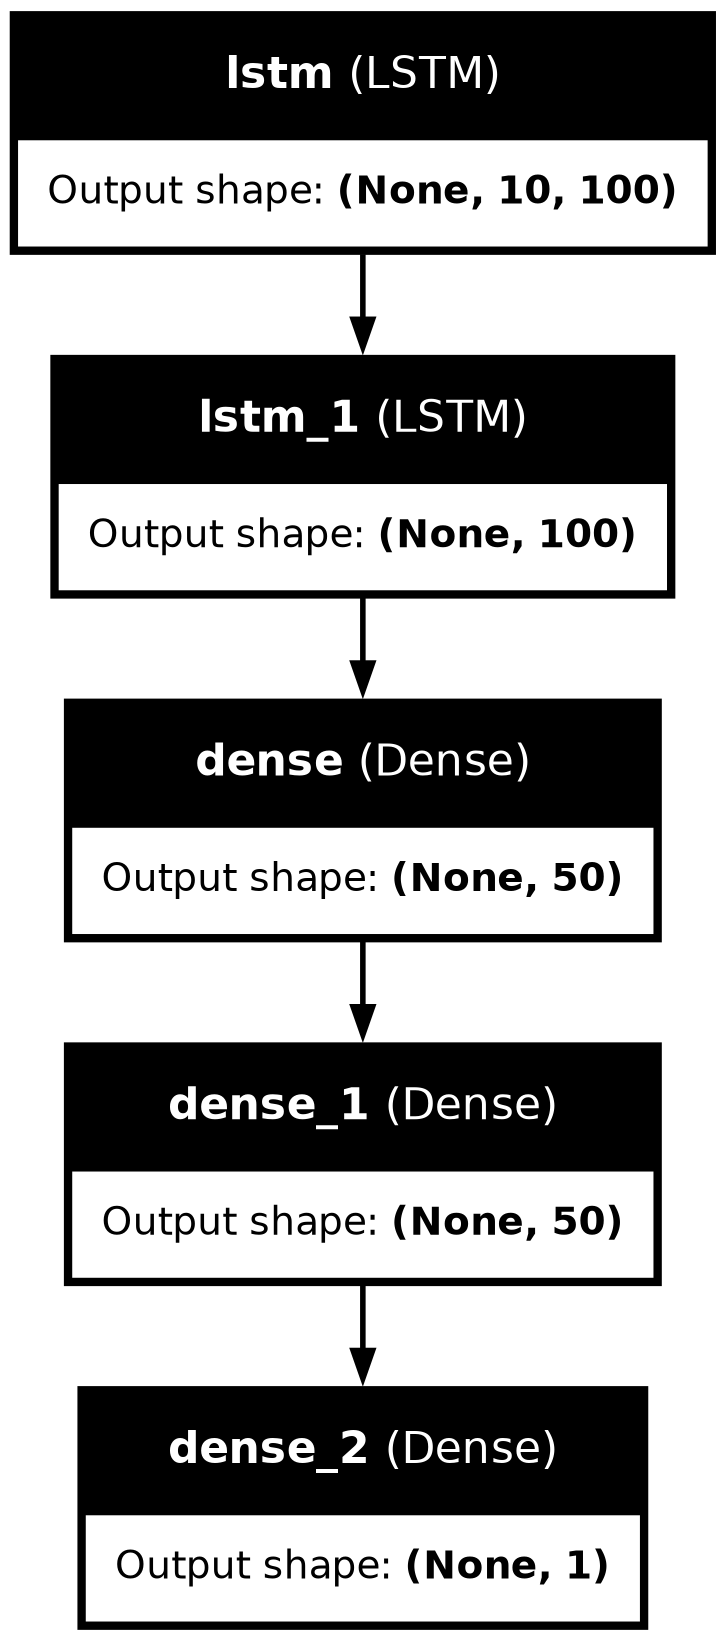

In [23]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Model Training

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0347
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056  
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098  
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056  
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075  
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062


### Validate Results

In [25]:
# Making predictions using the model
predictions = model.predict(x_test)

# Inverse transforming the scaled predictions
predictions = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


In [26]:
predictions

array([[199.09668],
       [199.4374 ],
       [200.2556 ],
       [201.38922],
       [202.71104],
       [204.6334 ],
       [206.11665],
       [207.9434 ],
       [210.03815],
       [211.80965],
       [212.4697 ],
       [212.66678],
       [212.46927]], dtype=float32)

Check $R^2$ Score

In [27]:
# Calculating Root Mean Squared Error (RMSE)
error = predictions - y_test
squared_error = error ** 2
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)

# Displaying RMSE
print('Root mean squared error:', rmse)

Root mean squared error: 6.858357361800966


#### Vizualize Predictions

In [28]:
# Get Validation Data
validation = data[training_data_len:]

# Add predictions to the validation set
validation['Predictions'] = predictions
validation

/tmp/ipykernel_95/2835727756.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2020-06-29,195.779999,198.529999,193.550003,198.440002,191.925766,26701600,199.096680
2020-06-30,197.880005,204.399994,197.740005,203.509995,196.829285,34310300,199.437393
2020-07-01,203.139999,206.350006,201.770004,204.699997,197.980209,32061200,200.255600
2020-07-02,205.679993,208.020004,205.000000,206.259995,199.489059,29315800,201.389221
2020-07-06,208.830002,211.130005,208.089996,210.699997,203.783264,31897600,202.711044
2020-07-07,210.449997,214.669998,207.990005,208.250000,201.413666,33600700,204.633408
2020-07-08,210.070007,213.259995,208.690002,212.830002,205.843353,33600000,206.116653
2020-07-09,216.330002,216.380005,211.470001,214.320007,207.284439,33121700,207.943405
2020-07-10,213.619995,214.080002,211.080002,213.669998,206.655746,26177600,210.038147


In [29]:
# Create a Plotly Express figure
fig = px.line(validation, x=validation.index, y=['Close', 'Predictions'], 
              title="Time Series Forecasting using LSTM",
              labels={"index": "Date-Time", "value": "Values"},
              line_dash_sequence=["solid", "dash"],
              color_discrete_sequence=['blue', 'red'])

# Show the figure
fig.show()

### Train Model (LSTM) with Sentiment

In [30]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-09,166.360001,167.369995,163.330002,165.139999,159.275269,51385100
2020-04-13,164.350006,165.570007,162.300003,165.509995,159.632156,41905300
2020-04-14,169.000000,173.750000,168.000000,173.699997,167.531326,52874300
2020-04-15,171.199997,173.570007,169.240005,171.880005,165.775925,40940800
2020-04-16,174.300003,177.279999,172.899994,177.039993,170.752655,50479600
...,...,...,...,...,...,...
2020-07-10,213.619995,214.080002,211.080002,213.669998,206.655746,26177600
2020-07-13,214.479996,215.800003,206.500000,207.070007,200.272446,38135600
2020-07-14,206.130005,208.850006,202.029999,208.350006,201.510437,37591800


### Add Sentiment to the Dataset

In [31]:
tweet_df

,index,id,created_at,full_text,sentiment_label,sentiment_score
0,3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,NEU,0.678378
1,30,34,2020-04-09 23:54:28+00:00,"$SPY $QQQ $VXX $AAPL $BA $MSFT\n\nGuys, I figu...",NEU,0.528815
2,58,64,2020-04-09 23:48:20+00:00,@QuisitiveInvest @inner_scorecard Its incredib...,POS,0.975222
3,154,160,2020-04-09 23:33:20+00:00,"$ZVTK looking for acquisitions in IoT, Busines...",NEU,0.875512
4,229,238,2020-04-09 23:18:27+00:00,RT @Barchart: Today's Most Active Options:\n\n...,NEU,0.960382
...,...,...,...,...,...,...
60057,923610,938609,2020-07-16 00:08:11+00:00,Testing 1 2 Buckle My Shoe 3 4 Get Their Passw...,NEU,0.973457
60058,923615,938614,2020-07-16 00:07:26+00:00,Here are just a few of the stocks that have so...,NEU,0.794156
60059,923619,938618,2020-07-16 00:05:54+00:00,"Trading Summary - July 15, 2020\n\n7 Trades - ...",NEU,0.962263
60060,923656,938656,2020-07-16 00:01:48+00:00,@_SeanDavid I could make a good case for why $...,NEU,0.708822


In [32]:
tweet_df['date'] = tweet_df.created_at.dt.date
tweet_df

,index,id,created_at,full_text,sentiment_label,sentiment_score,date
0,3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,NEU,0.678378,2020-04-09
1,30,34,2020-04-09 23:54:28+00:00,"$SPY $QQQ $VXX $AAPL $BA $MSFT\n\nGuys, I figu...",NEU,0.528815,2020-04-09
2,58,64,2020-04-09 23:48:20+00:00,@QuisitiveInvest @inner_scorecard Its incredib...,POS,0.975222,2020-04-09
3,154,160,2020-04-09 23:33:20+00:00,"$ZVTK looking for acquisitions in IoT, Busines...",NEU,0.875512,2020-04-09
4,229,238,2020-04-09 23:18:27+00:00,RT @Barchart: Today's Most Active Options:\n\n...,NEU,0.960382,2020-04-09
...,...,...,...,...,...,...,...
60057,923610,938609,2020-07-16 00:08:11+00:00,Testing 1 2 Buckle My Shoe 3 4 Get Their Passw...,NEU,0.973457,2020-07-16
60058,923615,938614,2020-07-16 00:07:26+00:00,Here are just a few of the stocks that have so...,NEU,0.794156,2020-07-16
60059,923619,938618,2020-07-16 00:05:54+00:00,"Trading Summary - July 15, 2020\n\n7 Trades - ...",NEU,0.962263,2020-07-16
60060,923656,938656,2020-07-16 00:01:48+00:00,@_SeanDavid I could make a good case for why $...,NEU,0.708822,2020-07-16


In [33]:
sentiment_df = tweet_df.groupby('date')['sentiment_score'].mean().reset_index()
sentiment_df

,date,sentiment_score
0,2020-04-09,0.822591
1,2020-04-10,0.823924
2,2020-04-11,0.812337
3,2020-04-12,0.836270
4,2020-04-13,0.834550
...,...,...
72,2020-07-12,0.838052
73,2020-07-13,0.850679
74,2020-07-14,0.869375
75,2020-07-15,0.861964


Merge Both the data

In [34]:
# Convert index of data to datetime
data.index = pd.to_datetime(data.index)

# Convert 'date' column in sentiment_df to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Merge data and sentiment_df on the date index
merged_df = pd.merge(data, sentiment_df, how='left', left_index=True, right_on='date')

# Fill missing sentiment scores with a default value, for example, 0
merged_df['sentiment_score'].fillna(0, inplace=True)

# Set 'date' as the index
merged_df.set_index('date', inplace=True)

merged_df

/tmp/ipykernel_95/3129627831.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,Open,High,Low,Close,Adj Close,Volume,sentiment_score
date,,,,,,,
2020-04-09,166.360001,167.369995,163.330002,165.139999,159.275269,51385100,0.822591
2020-04-13,164.350006,165.570007,162.300003,165.509995,159.632156,41905300,0.834550
2020-04-14,169.000000,173.750000,168.000000,173.699997,167.531326,52874300,0.838701
2020-04-15,171.199997,173.570007,169.240005,171.880005,165.775925,40940800,0.835618
2020-04-16,174.300003,177.279999,172.899994,177.039993,170.752655,50479600,0.826087
...,...,...,...,...,...,...,...
2020-07-10,213.619995,214.080002,211.080002,213.669998,206.655746,26177600,0.839618
2020-07-13,214.479996,215.800003,206.500000,207.070007,200.272446,38135600,0.850679
2020-07-14,206.130005,208.850006,202.029999,208.350006,201.510437,37591800,0.869375


### Train Model (LSTM) with Sentiment

In [35]:
def prepare_data(data):
    # Extract the 'Close' column from the data
    close_prices = data[['Close', 'sentiment_score']]
    
    # Get the values from the 'Close' column as a NumPy array
    values = close_prices.values
    
    return values

In [36]:
def scale_data(values):
    # Create a MinMaxScaler object and scale the values to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(values)
    
    return scaled_data, scaler

In [37]:
def split_data(scaled_data, training_percentage=0.8):
    # Calculate the length of the training data by taking 80% of the total length of the 'values' array
    training_data_len = math.ceil(len(scaled_data) * training_percentage)
    
    # Split the scaled data into training and test sets
    train_data = scaled_data[0:training_data_len, :]
    test_data = scaled_data[training_data_len -10:, :]
    
    return train_data, test_data, training_data_len

In [38]:
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i - sequence_length:i, :])
    return np.array(sequences)

In [39]:
def prepare_train_test(train_data, test_data, sequence_length=10):
    # Prepare training sequences and outputs
    x_train = create_sequences(train_data, sequence_length)
    y_train = train_data[sequence_length:, 0]  # Next value after the sequence
    
    # Prepare test sequences
    x_test = create_sequences(test_data, sequence_length)
    
    return x_train, y_train, x_test

In [40]:
def prepare_test_outputs(values, training_data_len):
    # Get the test outputs as a NumPy array from the 'values' array
    y_test = values[training_data_len:]
    y_test = np.array([x[0] for x in y_test])
    return y_test

In [41]:
values = prepare_data(merged_df)

# Scale data
scaled_data, scaler = scale_data(values)

# Split data
train_data, test_data, training_data_len = split_data(scaled_data)

# Prepare training and test sets
x_train, y_train, x_test = prepare_train_test(train_data, test_data)

# # Prepare test outputs
y_test = prepare_test_outputs(values, training_data_len)

### Model

In [42]:
del model

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 2)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(50))
model.add(layers.Dense(50))
model.add(layers.Dense(1))
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,251 (504.89 KB)

 Trainable params: 129,251 (504.89 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [43]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=10)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0528
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053  
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071  
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094  
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 


### Test Predictons

In [44]:
# Making predictions using the model
predictions = model.predict(x_test)
predictions = np.array([[x[0], 0] for x in predictions])

# Inverse transforming the scaled predictions
predictions = scaler.inverse_transform(predictions)
predictions = np.array([x[0] for x in predictions])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


In [45]:
# Calculating Root Mean Squared Error (RMSE)
error = predictions - y_test
squared_error = error ** 2
mean_squared_error = np.mean(squared_error)
rmse = np.sqrt(mean_squared_error)

# Displaying RMSE
print('Root mean squared error:', rmse)

Root mean squared error: 4.774250714094728


In [46]:
# Get Validation Data
validation = data[training_data_len:]

# Add predictions to the validation set
validation['Predictions'] = predictions
validation

/tmp/ipykernel_95/2835727756.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2020-06-29,195.779999,198.529999,193.550003,198.440002,191.925766,26701600,203.176812
2020-06-30,197.880005,204.399994,197.740005,203.509995,196.829285,34310300,203.739656
2020-07-01,203.139999,206.350006,201.770004,204.699997,197.980209,32061200,204.419871
2020-07-02,205.679993,208.020004,205.000000,206.259995,199.489059,29315800,205.279020
2020-07-06,208.830002,211.130005,208.089996,210.699997,203.783264,31897600,206.242463
2020-07-07,210.449997,214.669998,207.990005,208.250000,201.413666,33600700,207.553354
2020-07-08,210.070007,213.259995,208.690002,212.830002,205.843353,33600000,208.557420
2020-07-09,216.330002,216.380005,211.470001,214.320007,207.284439,33121700,209.802783
2020-07-10,213.619995,214.080002,211.080002,213.669998,206.655746,26177600,211.366988


In [47]:
# Create a Plotly Express figure
fig = px.line(validation, x=validation.index, y=['Close', 'Predictions'], 
              title="Time Series Forecasting using LSTM",
              labels={"index": "Date-Time", "value": "Values"},
              line_dash_sequence=["solid", "dash"],
              color_discrete_sequence=['blue', 'red'])

# Show the figure
fig.show()